# General

In [84]:
# run.py
import numpy as np
import matplotlib.pyplot as plt 
from proj1_helpers import *
from auxiliary_functions import *

In [2]:
def calculate_precision(y, y_pred, zeros_ones=False):
    if len(np.array(y).shape) > 1:
        y=y.flatten()
    if len(np.array(y_pred).shape) > 1:
        y_pred=y_pred.flatten()
    if zeros_ones:
        incorrect = np.sum(np.abs(y - y_pred))
    else:
        incorrect = np.sum(np.abs(y - y_pred))/2
    precision = 1 - (incorrect / y.shape[0])
    return precision

def predict_labels_bis(weights, data, return_zeros=False):
    """Generates class predictions given weights, and a test data matrix"""
    y_pred = np.dot(data, weights)
    if return_zeros:
        y_pred[np.where(y_pred <= 0.5)] = 0
    else:
        y_pred[np.where(y_pred <= 0.5)] = -1
    y_pred[np.where(y_pred > 0.5)] = 1

    return y_pred

In [3]:
DATA_PATH = '../data/'

#### Read files and prepare data

In [4]:
yb, input_data, ids = load_csv_data(DATA_PATH+'train.csv')

In [5]:
test_yb, test_input_data, test_ids = load_csv_data(DATA_PATH+'test.csv')

#### In case we need to change the labels (we now need to do it for logistic regression)

In [6]:
y = np.ones(len(yb))
y[np.where(yb==-1)] = 0

In [7]:
Y=np.array((yb, y)).T

Y.T[0] has labels {-1, 1}

Y.T[1] has labels {0, 1}

#### Fix weird values

In [8]:
clean_data = input_data
clean_data[np.where(input_data==-999)] = 0

test_clean_data = test_input_data
test_clean_data[np.where(input_data==-999)] = 0

#### Normalize

In [9]:
x, mean_x, std_x = standardize(clean_data)
test_x, test_mean_x, test_std_x = standardize(test_clean_data)

#### Keep some columns only

In [10]:
small_x = x[:, [0,1,2,10,11,13]]
test_small_x = test_x[:, [0,1,2,10,11,13]]

#### Build poly

In [11]:
poly_tx = build_poly(small_x, 2)
test_poly_tx = build_poly(test_small_x, 2)

#### Split data: 80% for training and 20% for testing. Out of the training, 80% is for *training* and 20% for validation

In [12]:
tv_tx, te_tx, tv_Y, te_Y = split_data(poly_tx, Y, .8)

In [13]:
tr_tx, va_tx, tr_Y, va_Y = split_data(tv_tx, tv_Y, .8)

# Ridge regression

In [14]:
from implementations import ridge_regression

In [15]:
tr_y = tr_Y.T[0]
va_y = va_Y.T[0]
te_y = te_Y.T[0]

In [16]:
tr_errors = []
va_errors = []
ws = []

lambdas = np.logspace(-2, 5, num=30)

for lambda_ in lambdas:
    w, loss = ridge_regression(tr_y, tr_tx, lambda_)
    tr_y_pred = predict_labels(w, tr_tx)
    va_y_pred = predict_labels(w, va_tx)
    tr_error = 1 - calculate_precision(tr_y, tr_y_pred)
    va_error = 1 - calculate_precision(va_y, va_y_pred)
    ws.append(w)
    tr_errors.append(tr_error)
    va_errors.append(va_error)

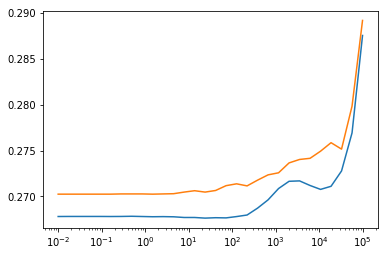

In [17]:
plt.semilogx(lambdas, tr_errors)
plt.semilogx(lambdas, va_errors)
plt.show()

We can choose $\lambda=10^{2}$

In [18]:
lambda_ = 1e2
w, loss = ridge_regression(tr_y, tr_tx, lambda_)
te_y_pred = predict_labels(w, te_tx)
calculate_precision(te_y_pred, te_y)

0.73304000000000002

0.73304000000000002

Get submission:

In [19]:
test_y_pred = predict_labels(w, test_poly_tx)
create_csv_submission(test_ids, test_y_pred, DATA_PATH+'ridge_submission_upd.csv')

# Logistic Regression

In [20]:
from implementations import logistic_regression

In [21]:
np.random.seed(1)

In [22]:
tr_y = tr_Y.T[1]
va_y = va_Y.T[1]
te_y = te_Y.T[1]

In [23]:
initial_w = np.zeros((tr_tx.shape[1], 1))
max_iters = 40
ws = []
losses = []
tr_errors = []
va_errors = []
gammas = np.logspace(-5, -2.5, 10)
for gamma in gammas:
    w, loss = logistic_regression(tr_y, tr_tx, initial_w, max_iters, gamma)
    tr_y_pred = predict_labels_bis(w, tr_tx, return_zeros=True)
    va_y_pred = predict_labels_bis(w, va_tx, return_zeros=True)
    tr_error = 1 - calculate_precision(tr_y, tr_y_pred, zeros_ones=True)
    va_error = 1 - calculate_precision(va_y, va_y_pred, zeros_ones=True)
    tr_errors.append(tr_error)
    va_errors.append(va_error)
    ws.append(w)
    losses.append(loss)

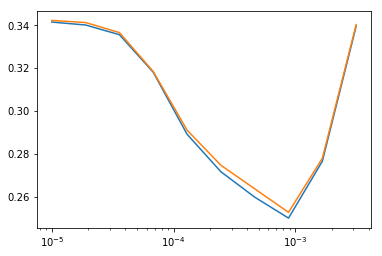

In [24]:
plt.semilogx(gammas, tr_errors)
plt.semilogx(gammas, va_errors)
plt.show()

Final choice:

In [25]:
np.random.seed(1)

In [26]:
gamma = 1e-3
max_iters = 100
initial_w = np.zeros((tr_tx.shape[1], 1))
w, loss = logistic_regression(tr_y, tr_tx, initial_w, max_iters, gamma)

Test it

In [27]:
calculate_precision(predict_labels_bis(w, te_tx, return_zeros=True), te_y, zeros_ones=True)

0.74981999999999993

0.74981999999999993

Get submission:

In [28]:
test_y_pred = predict_labels_bis(w, test_poly_tx)
create_csv_submission(test_ids, test_y_pred, DATA_PATH+'lr_submission_upd.csv')

# Logistic Regression with adaptive lambda

In [61]:
np.random.seed(1)

In [62]:
tr_y = tr_Y.T[1]
va_y = va_Y.T[1]
te_y = te_Y.T[1]

In [63]:
def logistic_regression_improved(y, tx, initial_w, max_iters, gamma,
    batch_size=1000, return_all=False):
    """Logistic regression, with adaptive lambda"""
    if len(tx.shape) == 1:
        tx = tx.reshape(-1, 1)
    if len(y.shape) == 1:
        y = y.reshape(-1, 1)
    initial_w = np.array(initial_w).reshape(tx.shape[1], 1)
    
    # init parameters    
    w = initial_w
    if return_all:
        ws = [w]
        losses = []

    for n_iter in range(max_iters):
        # get mini-batch
        y_n, tx_n = get_batch(y, tx, batch_size)
        # get loss and update w by gradient
        loss, w = logistic_by_gd(y_n, tx_n, w, next(gamma))
        if return_all:
            # store w and loss
            ws.append(w)
            losses.append(loss)
            if n_iter % 100 == 0:
                print("Current iteration={i}, loss={l}".format(i=n_iter, l=loss))
    # return w and loss, either all or only last ones
    if return_all:
        return ws, losses
    else:
        return w, loss

In [64]:
initial_w = np.zeros((tr_tx.shape[1], 1))
max_iters = 40
ws = []
losses = []
tr_errors = []
va_errors = []

gammas = [(np.random.uniform(.1,.9), np.random.randint(-4,-2)) for k in range(20)]

for g in gammas:
    gamma = adaptive_gamma(kappa=g[0], eta0=10**g[1])
    w, loss = logistic_regression_improved(tr_y, tr_tx, initial_w, max_iters, gamma)
    tr_y_pred = predict_labels_bis(w, tr_tx, return_zeros=True)
    va_y_pred = predict_labels_bis(w, va_tx, return_zeros=True)
    tr_error = 1 - calculate_precision(tr_y, tr_y_pred, zeros_ones=True)
    va_error = 1 - calculate_precision(va_y, va_y_pred, zeros_ones=True)
    tr_errors.append(tr_error)
    va_errors.append(va_error)
    ws.append(w)
    losses.append(loss)

In [65]:
gammas

[(0.43361760376205927, -4),
 (0.846045887470927, -3),
 (0.3418660581054718, -3),
 (0.28887118156158087, -3),
 (0.24900816910213674, -3),
 (0.635796829442784, -3),
 (0.5310533872026856, -4),
 (0.35061881354582014, -4),
 (0.263561799785214, -4),
 (0.2836617709838605, -4),
 (0.6363740081427218, -3),
 (0.4657638463895907, -3),
 (0.21230955087618703, -4),
 (0.7227113890692268, -3),
 (0.874609260575518, -3),
 (0.17424064691259034, -3),
 (0.8011113218368306, -4),
 (0.7633175258937133, -4),
 (0.1312438265863059, -3),
 (0.1473945610412508, -4)]

In [66]:
tr_errors

[0.33744375000000004,
 0.28513125000000006,
 0.25940625000000006,
 0.25688749999999994,
 0.2623875,
 0.27257500000000001,
 0.33876250000000008,
 0.33413749999999998,
 0.32946249999999999,
 0.33160000000000001,
 0.26643749999999999,
 0.26458749999999998,
 0.32883125000000002,
 0.27803124999999995,
 0.27839999999999998,
 0.26129999999999998,
 0.34065624999999999,
 0.34056874999999998,
 0.25358124999999998,
 0.31857500000000005]

In [67]:
va_errors

[0.33804999999999996,
 0.28687499999999999,
 0.26255000000000006,
 0.26037500000000002,
 0.26642500000000002,
 0.27564999999999995,
 0.33945000000000003,
 0.33472499999999994,
 0.32994999999999997,
 0.33240000000000003,
 0.26897499999999996,
 0.26772499999999999,
 0.32942500000000008,
 0.28092499999999998,
 0.28167500000000001,
 0.26507499999999995,
 0.34182500000000005,
 0.34172500000000006,
 0.25705,
 0.319025]

Final choice:

In [114]:
np.random.seed(1)

In [115]:
initial_w = np.zeros((tr_tx.shape[1], 1))
max_iters = 100
gamma = adaptive_gamma(kappa=0.1, eta0=1e-3)
w, loss = logistic_regression_improved(tr_y, tr_tx, initial_w, max_iters, gamma, batch_size=1000)

Test it

In [116]:
calculate_precision(predict_labels_bis(w, te_tx, return_zeros=True), te_y, zeros_ones=True)

0.74371999999999994

0.74371999999999994

Submission:

In [77]:
test_y_pred = predict_labels_bis(w, test_poly_tx)
create_csv_submission(test_ids, test_y_pred, DATA_PATH+'lri_submission_upd.csv')

# Regularized logistic regression

In [120]:
np.random.seed(1)

In [121]:
from implementations import reg_logistic_regression

Check different gammas and lambdas:

In [125]:
initial_w = np.zeros((tr_tx.shape[1], 1))
max_iters = 20
ws=[]
tr_errors=[]
te_errors=[]
losses = []

gammas = np.logspace(-5, 5, 11)
lambdas = np.logspace(-3, 3, num=7)

for gamma in gammas:
    for lambda_ in lambdas:
        w, loss = reg_logistic_regression(tr_y, tr_tx, lambda_, initial_w, max_iters, gamma, batch_size=2000)        
        tr_y_pred = predict_labels_bis(w, tr_tx, return_zeros=True)
        va_y_pred = predict_labels_bis(w, va_tx, return_zeros=True)
        tr_error = 1 - calculate_precision(tr_y, tr_y_pred, zeros_ones=True)
        va_error = 1 - calculate_precision(va_y, va_y_pred, zeros_ones=True)
        tr_errors.append(tr_error)
        va_errors.append(va_error)
        print()
        print(lambda_)
        print(gamma)
        print(va_error)
        
        ws.append(w)
        losses.append(loss)


0.0001
0.001
0.2858

0.001
0.001
0.261375

0.01
0.001
0.254475


/home/lmon/repositories/03-ML/ml2017-proj/project1/scripts/auxiliary_functions.py:96: RuntimeWarning: overflow encountered in exp
  # compute the cost
/home/lmon/repositories/03-ML/ml2017-proj/project1/scripts/auxiliary_functions.py:108: RuntimeWarning: overflow encountered in exp
  # update w
/home/lmon/repositories/03-ML/ml2017-proj/project1/scripts/auxiliary_functions.py:109: RuntimeWarning: invalid value encountered in true_divide
  w_1 = w
/home/lmon/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in less_equal
/home/lmon/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in greater



0.0001
0.01
nan

0.001
0.01
nan

0.01
0.01
nan

0.0001
0.1
nan

0.001
0.1
nan

0.01
0.1
nan

0.0001
1.0
nan

0.001
1.0
nan

0.01
1.0
nan

0.0001
10.0
nan

0.001
10.0
nan

0.01
10.0
nan

0.0001
100.0
nan

0.001
100.0
nan

0.01
100.0
nan


Final choice:

In [127]:
np.random.seed(1)

gamma = .001
lambda_ = .01
max_iters = 100
initial_w = np.zeros((tr_tx.shape[1], 1))
w, loss = reg_logistic_regression(tr_y, tr_tx, lambda_, initial_w, max_iters,
    gamma, batch_size=2000)

Test it:

In [128]:
calculate_precision(predict_labels_bis(w, te_tx, return_zeros=True), te_y, zeros_ones=True)

0.75375999999999999

# Improved regularized logistic regression with adaptive gamma

In [85]:
np.random.seed(1)

In [86]:
def reg_logistic_regression_improved(y, tx, lambda_, initial_w, max_iters,
    gamma, batch_size=1000, return_all=False):
    """Regularized logistic regression using mini-batch gradient descent.
    Uses adaptive lambda and does not penalize offset."""
    if len(tx.shape) == 1:
        tx = tx.reshape(-1, 1)
    if len(y.shape) == 1:
        y = y.reshape(-1, 1)
    initial_w = np.array(initial_w).reshape(tx.shape[1], 1)

    # init parameters
    w = initial_w
    if return_all:
        ws = [w]
        losses = []

    for n_iter in range(max_iters):
        # get mini-batch
        y_n, tx_n = get_batch(y, tx, batch_size)
        # get loss and update w by gradient
        loss, w = reg_logistic_by_gd(y_n, tx_n, lambda_, w, next(gamma), False)
        if return_all:
            # store w and loss
            ws.append(w)
            losses.append(loss)
            if n_iter % 100 == 0:
                print("Current iteration={i}, loss={l}".format(i=n_iter, l=loss))
    # return w and loss, either all or only last ones
    if return_all:
        return ws, losses
    else:
        return w, loss

Check different gammas and lambdas:

In [91]:
initial_w = np.zeros((tr_tx.shape[1], 1))
max_iters = 20
ws=[]
tr_errors=[]
te_errors=[]
losses = []

gammas = [(np.random.uniform(.05,.9), np.random.randint(-3,-1)) for k in range(10)]
lambdas = np.logspace(-3, 3, num=7)

for g in gammas:
    for lambda_ in lambdas:
        gamma = adaptive_gamma(kappa=g[0], eta0=10**g[1])
        w, loss = reg_logistic_regression_improved(tr_y, tr_tx, lambda_, initial_w, max_iters, gamma)        
        tr_y_pred = predict_labels_bis(w, tr_tx, return_zeros=True)
        va_y_pred = predict_labels_bis(w, va_tx, return_zeros=True)
        tr_error = 1 - calculate_precision(tr_y, tr_y_pred, zeros_ones=True)
        va_error = 1 - calculate_precision(va_y, va_y_pred, zeros_ones=True)
        tr_errors.append(tr_error)
        va_errors.append(va_error)
        print()
        print(lambda_)
        print(g)
        print(va_error)
        
        ws.append(w)
        losses.append(loss)


0.001
(0.4144666096098798, -3)
0.268275

0.01
(0.4144666096098798, -3)
0.26645

0.1
(0.4144666096098798, -3)
0.262625

1.0
(0.4144666096098798, -3)
0.2603

10.0
(0.4144666096098798, -3)
0.2692

100.0
(0.4144666096098798, -3)
0.280125

1000.0
(0.4144666096098798, -3)
0.34275

0.001
(0.6779804887602191, -2)
0.21955

0.01
(0.6779804887602191, -2)
0.22105

0.1
(0.6779804887602191, -2)
0.2247

1.0
(0.6779804887602191, -2)
0.224975

10.0
(0.6779804887602191, -2)
0.237125

100.0
(0.6779804887602191, -2)
0.25385


/home/lmon/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:15: RuntimeWarning: overflow encountered in exp
/home/lmon/repositories/03-ML/ml2017-proj/project1/scripts/auxiliary_functions.py:108: RuntimeWarning: overflow encountered in exp
  # update w
/home/lmon/repositories/03-ML/ml2017-proj/project1/scripts/auxiliary_functions.py:109: RuntimeWarning: invalid value encountered in true_divide
  w_1 = w
/home/lmon/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in less_equal
/home/lmon/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in greater



1000.0
(0.6779804887602191, -2)
nan

0.001
(0.6298227205333596, -2)
0.217975

0.01
(0.6298227205333596, -2)
0.2279

0.1
(0.6298227205333596, -2)
0.224025

1.0
(0.6298227205333596, -2)
0.2456

10.0
(0.6298227205333596, -2)
0.2233

100.0
(0.6298227205333596, -2)
0.26695

1000.0
(0.6298227205333596, -2)
nan

0.001
(0.548120153411696, -3)
0.270675

0.01
(0.548120153411696, -3)
0.2721

0.1
(0.548120153411696, -3)
0.2683

1.0
(0.548120153411696, -3)
0.270675

10.0
(0.548120153411696, -3)
0.2693

100.0
(0.548120153411696, -3)
0.287725

1000.0
(0.548120153411696, -3)
0.341525

0.001
(0.40848324300629346, -2)
0.27885

0.01
(0.40848324300629346, -2)
0.268725

0.1
(0.40848324300629346, -2)
0.2666

1.0
(0.40848324300629346, -2)
0.24485

10.0
(0.40848324300629346, -2)
0.275975

100.0
(0.40848324300629346, -2)
0.338675

1000.0
(0.40848324300629346, -2)
nan

0.001
(0.6510415341636413, -2)
0.239025

0.01
(0.6510415341636413, -2)
0.22145

0.1
(0.6510415341636413, -2)
0.223

1.0
(0.6510415341636413, -2

Repeat in a smaller range of parameters:

In [93]:
initial_w = np.zeros((tr_tx.shape[1], 1))
max_iters = 40
ws=[]
tr_errors=[]
te_errors=[]
losses = []

gammas = [(np.random.uniform(.5,.8), -2) for k in range(10)]
lambdas = np.logspace(-3, 1, num=4)

for g in gammas:
    for lambda_ in lambdas:
        gamma = adaptive_gamma(kappa=g[0], eta0=10**g[1])
        w, loss = reg_logistic_regression_improved(tr_y, tr_tx, lambda_, initial_w, max_iters, gamma)        
        tr_y_pred = predict_labels_bis(w, tr_tx, return_zeros=True)
        va_y_pred = predict_labels_bis(w, va_tx, return_zeros=True)
        tr_error = 1 - calculate_precision(tr_y, tr_y_pred, zeros_ones=True)
        va_error = 1 - calculate_precision(va_y, va_y_pred, zeros_ones=True)
        tr_errors.append(tr_error)
        va_errors.append(va_error)
        print()
        print(lambda_)
        print(g)
        print(va_error)
        
        ws.append(w)
        losses.append(loss)


0.001
(0.7811277484042665, -2)
0.2201

0.0215443469003
(0.7811277484042665, -2)
0.21995

0.464158883361
(0.7811277484042665, -2)
0.22475

10.0
(0.7811277484042665, -2)
0.233375

0.001
(0.6805780148797523, -2)
0.23775

0.0215443469003
(0.6805780148797523, -2)
0.22325

0.464158883361
(0.6805780148797523, -2)
0.237525

10.0
(0.6805780148797523, -2)
0.245475

0.001
(0.7382012836849072, -2)
0.220675

0.0215443469003
(0.7382012836849072, -2)
0.224975

0.464158883361
(0.7382012836849072, -2)
0.215625

10.0
(0.7382012836849072, -2)
0.253975

0.001
(0.7547460441047553, -2)
0.215825

0.0215443469003
(0.7547460441047553, -2)
0.22

0.464158883361
(0.7547460441047553, -2)
0.22135

10.0
(0.7547460441047553, -2)
0.238425


/home/lmon/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:15: RuntimeWarning: overflow encountered in exp
/home/lmon/repositories/03-ML/ml2017-proj/project1/scripts/auxiliary_functions.py:108: RuntimeWarning: overflow encountered in exp
  # update w
/home/lmon/repositories/03-ML/ml2017-proj/project1/scripts/auxiliary_functions.py:109: RuntimeWarning: invalid value encountered in true_divide
  w_1 = w
/home/lmon/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in less_equal
/home/lmon/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in greater



0.001
(0.7024348800263576, -2)
nan

0.0215443469003
(0.7024348800263576, -2)
0.229125

0.464158883361
(0.7024348800263576, -2)
0.2271

10.0
(0.7024348800263576, -2)
0.242975

0.001
(0.6326542261454162, -2)
0.220125

0.0215443469003
(0.6326542261454162, -2)
0.2179

0.464158883361
(0.6326542261454162, -2)
0.227325

10.0
(0.6326542261454162, -2)
0.247

0.001
(0.6789481107794665, -2)
0.222325

0.0215443469003
(0.6789481107794665, -2)
0.2295

0.464158883361
(0.6789481107794665, -2)
0.218

10.0
(0.6789481107794665, -2)
0.24185

0.001
(0.7433874619669785, -2)
nan

0.0215443469003
(0.7433874619669785, -2)
0.222475

0.464158883361
(0.7433874619669785, -2)
0.2296

10.0
(0.7433874619669785, -2)
0.2443

0.001
(0.6991490849407433, -2)
0.22505

0.0215443469003
(0.6991490849407433, -2)
0.23825

0.464158883361
(0.6991490849407433, -2)
0.22805

10.0
(0.6991490849407433, -2)
0.257125

0.001
(0.5424729465111501, -2)
0.22085

0.0215443469003
(0.5424729465111501, -2)
0.228125

0.464158883361
(0.5424729465

Final choice:

In [94]:
np.random.seed(1)

initial_w = np.zeros((tr_tx.shape[1], 1))
max_iters = 200
gamma = adaptive_gamma(kappa=0.7, eta0=1e-2)
lambda_= 0.1
w, loss = reg_logistic_regression_improved(tr_y, tr_tx, lambda_, initial_w,
                                           max_iters, gamma)

Test it:

In [95]:
calculate_precision(predict_labels_bis(w, te_tx, return_zeros=True), te_y, zeros_ones=True)

0.75394000000000005

0.75394000000000005

In [96]:
test_y_pred = predict_labels_bis(w, test_poly_tx)
create_csv_submission(test_ids, test_y_pred, DATA_PATH+'rlri_submission_upd.csv')

# Cross validation

Ridge regression using k-fold

In [ ]:
def build_k_indices(y, k_fold, seed):
    '''
    Build k indices for k-fold.
    '''
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

def split_data_k_indices(y, x, k_indices, k):
    '''
    Splits the data into test and training data.
    Samples get randomized through 'k_indices' and
    selected through 'k'.
    '''
    mask = np.ones(k_indices.shape, dtype=bool)
    mask[k] = False
    
    # Test data
    x_test = x[k_indices[k]]
    y_test = y[k_indices[k]]
    
    # Train data
    x_train = x[k_indices[mask]]
    y_train = y[k_indices[mask]]
    
    return x_test, y_test, x_train, y_train

In [ ]:
def cross_validation(y, x, k_indices, k, lambda_, degree):
    '''
    Return the loss of ridge regression.
    '''
    # Split data according to 'k_indices' and 'k'
    x_test, y_test, x_train, y_train = split_data_k_indices(y, x, k_indices, k)

    # Form data with polynomial degree
    # tx_test = build_poly(x_test, degree)
    # tx_train = build_poly(x_train, degree)

    # Apply ridge regression
    w_opt, rmse_train = ridge_regression(y_train, x_train, lambda_)
    
    prediction = {
        'train': predict_labels(w_opt, x_train),
        'test': predict_labels(w_opt, x_test)
    } 
    
    precision = {
        'train': calculate_precision(prediction['train'], y_train),
        'test': calculate_precision(prediction['test'], y_test)
    }
    
    # Return loss for train and test data
    return precision['train'], precision['test']

In [ ]:
def cross_validation_visualization(lambds, mse_tr, mse_te, mse_dif):
    """visualization the curves of mse_tr and mse_te."""
    plt.semilogx(lambds, mse_tr, marker=".", color='b', label='train error')
    plt.semilogx(lambds, mse_te, marker=".", color='r', label='test error')
    plt.semilogx(lambds, mse_dif, marker=".", color='y', label='error delta')
    plt.xlabel("lambda")
    plt.ylabel("rmse")
    plt.title("cross validation")
    plt.legend(loc=2)
    plt.grid(True)
    plt.show()

In [ ]:
degree = 7
k_fold = 3
seed = 13

lambdas = np.logspace(-40, 40, 30)

# split data in k fold
k_indices = build_k_indices(y, k_fold, seed)

lambda_avg_rmse_trs = []
lambda_avg_rmse_tes = []
lambda_avg_rmse_difs = []

for lambda_ in lambdas:
    
    rmse_trs = []
    rmse_tes = []
    rmse_difs = []

    # K-fold cross validation and pick the rmse 'test' and 'train'
    # errors that represent the least absolute difference between
    # them (for a given lambda).
    for k in range(k_fold):
        rmse_cur_tr, rmse_cur_te = cross_validation(y, x, k_indices, k, lambda_, degree)
        
        rmse_trs.append(rmse_cur_tr)
        rmse_tes.append(rmse_cur_te)
        rmse_difs.append(abs(rmse_cur_tr - rmse_cur_te))
        
    lambda_avg_rmse_trs.append(np.mean(rmse_trs))
    lambda_avg_rmse_tes.append(np.mean(rmse_tes))
    lambda_avg_rmse_difs.append(np.mean(rmse_difs))

cross_validation_visualization(lambdas, lambda_avg_rmse_trs, lambda_avg_rmse_tes, lambda_avg_rmse_difs)

Read test data

In [ ]:
test_yb, test_input_data, test_ids = load_csv_data(DATA_PATH+'test.csv')

Predict labels:

In [ ]:
test_y_pred = predict_labels(w_opt, test_input_data)

Create submission:

In [ ]:
create_csv_submission(test_ids, test_y_pred, DATA_PATH+'submission.csv')